In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm
import matplotlib
from matplotlib.gridspec import GridSpec

import xesmf as xe
#from pykrige.ok import OrdinaryKrigingg
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils
import os

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs

import geopandas

In [2]:
## look at https://wedocs.unep.org/bitstream/handle/20.500.11822/11406/Pog_&amp;_iPog_-_Energy_and_Fuels.pdf?sequence=1&amp%3BisAllowed=

## for emissions factors scaling

## fix tott

## Set constants

In [3]:
years = np.arange(0,41)[::5]
percents = np.arange(0,101)[::5]

#indo_years = np.arange(0,41)[::2]

receptor_locs = ['China']#, 'Indonesia', 'Malaysia', 'Vietnam', 'Australia', 'Cambodia', 'Myanmar', 'Laos', 'Philippines', 'Nepal', 'Bangladesh', 'Thailand', 'Bhutan']
emission_locs = ['MALAYSIA', 'INDONESIA', 'VIETNAM', 'SUM'] #'CAMBODIA' not using bc no emissions of existing plants

In [4]:
## Add time dimension
length_simulation = 50*365
time_array = np.arange(0, length_simulation)

## Data read in

### Emissions dataframe

In [5]:
CGP_df = pd.read_csv('mod_coal_inputs/BC_SE_Asia_all_financing_SEA_GAINS_Springer.csv')

In [6]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [7]:
CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})

## Read in concentrations

In [8]:
intensity_da = {}
intensity_ds = {}
for emis_loc in emission_locs:
    intensity_da[emis_loc] = {}
    intensity_ds[emis_loc] = {}
    for receptor_loc in receptor_locs:
        intensity_da[emis_loc][receptor_loc] = pd.DataFrame(columns = years, index = percents)
        
for emis_loc in emission_locs:
    for yr in years:
        for pc in percents:
            if os.path.exists(f'Outputs/weighted_co2_old/C_out_{emis_loc}_weighted_{pc}pct_{yr}yr.nc'):
                da = pd.read_csv(f'Outputs/weighted_co2_old/C_out_{emis_loc}_weighted_{pc}pct_{yr}yr.nc', index_col = 0)
               # print(yr,pc)
                for receptor_loc in receptor_locs:
                    intensity_da[emis_loc][receptor_loc].loc[pc, yr] = da.loc[receptor_loc]['BC_Conc'].astype('float64')
                    intensity_da[emis_loc][receptor_loc] = intensity_da[emis_loc][receptor_loc].astype('float64').fillna(0)
                    intensity_ds[emis_loc][receptor_loc] = intensity_da[emis_loc][receptor_loc].stack().to_xarray().rename({'level_0':'percent', 'level_1':'year'})
                    
for receptor_loc in receptor_locs:
    intensity_ds['SUM'][receptor_loc] = (intensity_ds['MALAYSIA'][receptor_loc].fillna(0) + intensity_ds['INDONESIA'][receptor_loc].fillna(0) + intensity_ds['VIETNAM'][receptor_loc].fillna(0))
    
intensity_dict = {}
for m in intensity_ds.keys():
    intensity_dict[m] = xr.concat([intensity_ds[m][t] for t in intensity_ds[m].keys()], pd.Index([t for t in intensity_ds[m].keys()], name='receptor_loc'), join = 'outer')
    ds1 = xr.concat([intensity_dict[m] for m in intensity_dict.keys()], pd.Index([m for m in intensity_dict.keys()], name='emis_loc'), join = 'outer')


In [9]:
annual_da = {}
annual_ds = {}
for emis_loc in emission_locs:
    annual_da[emis_loc] = {}
    annual_ds[emis_loc] = {}
    for receptor_loc in receptor_locs:
        annual_da[emis_loc][receptor_loc] = pd.DataFrame(columns = years, index = percents)
        
for emis_loc in emission_locs:
    for yr in years:
        for pc in percents:
            if os.path.exists(f'Outputs/annual_co2_old/C_out_{emis_loc}_annual_{pc}pct_{yr}yr.nc'):
                da = pd.read_csv(f'Outputs/annual_co2_old/C_out_{emis_loc}_annual_{pc}pct_{yr}yr.nc', index_col = 0)
               # print(yr,pc)
                for receptor_loc in receptor_locs:
                    annual_da[emis_loc][receptor_loc].loc[pc, yr] = da.loc[receptor_loc]['BC_Conc'].astype('float64')
                    annual_da[emis_loc][receptor_loc] = annual_da[emis_loc][receptor_loc].astype('float64').fillna(0)
                    annual_ds[emis_loc][receptor_loc] = annual_da[emis_loc][receptor_loc].stack().to_xarray().rename({'level_0':'percent', 'level_1':'year'})
                    
for receptor_loc in receptor_locs:
    annual_ds['SUM'][receptor_loc] = (annual_ds['MALAYSIA'][receptor_loc].fillna(0) + annual_ds['INDONESIA'][receptor_loc].fillna(0) + annual_ds['VIETNAM'][receptor_loc].fillna(0))
    
annual_dict = {}
for m in annual_ds.keys():
    annual_dict[m] = xr.concat([annual_ds[m][t] for t in annual_ds[m].keys()], pd.Index([t for t in annual_ds[m].keys()], name='receptor_loc'), join = 'outer')
    ds2 = xr.concat([annual_dict[m] for m in annual_dict.keys()], pd.Index([m for m in annual_dict.keys()], name='emis_loc'), join = 'outer')


In [10]:
age_da = {}
age_ds = {}
for emis_loc in emission_locs:
    age_da[emis_loc] = {}
    age_ds[emis_loc] = {}
    for receptor_loc in receptor_locs:
        age_da[emis_loc][receptor_loc] = pd.DataFrame(index = years, columns = ['conc'])
        
for emis_loc in emission_locs:
    for yr in years:
        if os.path.exists(f'Outputs/retire_age_old/C_out_{emis_loc}_age_{yr}yr.nc'):
            da = pd.read_csv(f'Outputs/retire_age_old/C_out_{emis_loc}_age_{yr}yr.nc', index_col = 0)
            for receptor_loc in receptor_locs:
                age_da[emis_loc][receptor_loc].loc[yr] = da.loc[receptor_loc]['BC_Conc'].astype('float64')
                age_da[emis_loc][receptor_loc] = age_da[emis_loc][receptor_loc].astype('float64').fillna(0)
                age_ds[emis_loc][receptor_loc] = age_da[emis_loc][receptor_loc].stack().to_xarray().rename({'level_0':'year'}).drop('level_1')

for receptor_loc in receptor_locs:
    age_ds['SUM'][receptor_loc] = (age_ds['MALAYSIA'][receptor_loc].fillna(0) + age_ds['INDONESIA'][receptor_loc].fillna(0) + age_ds['VIETNAM'][receptor_loc].fillna(0))

age_dict = {}
for m in age_ds.keys():
    age_dict[m] = xr.concat([age_ds[m][t] for t in age_ds[m].keys()], pd.Index([t for t in age_ds[m].keys()], name='receptor_loc'), join = 'outer')
    ds3 = xr.concat([age_dict[m] for m in age_dict.keys()], pd.Index([m for m in age_dict.keys()], name='emis_loc'), join = 'outer')


In [11]:
ds = xr.concat([ds1, ds2, ds3], pd.Index(['intensity_co2','annual_co2','retire_age'], name='shutdown_type'), join = 'outer', coords = 'minimal')


## Plot emissions of CO2 vs BC

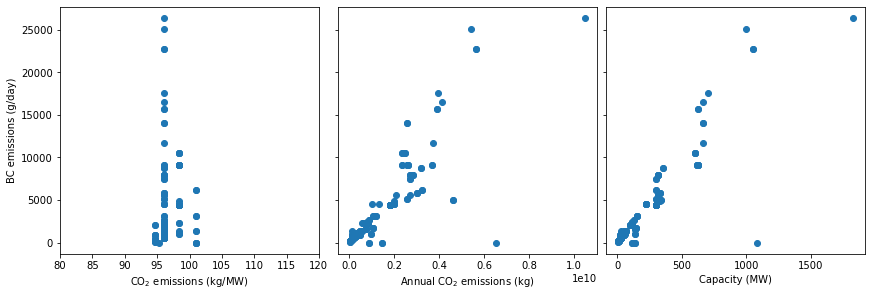

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4), sharey = True, constrained_layout = True)

ax1.plot(CGP_df['EMISFACTOR.CO2']/1e3, CGP_df['BC_(g/day)'], 'o')
#ax1.set_xticks(rotation = 90);
ax1.set_ylabel('BC emissions (g/day)')
ax1.set_ylabel('BC emissions (g/day)')
ax1.set_xlabel('CO$_2$ emissions (kg/MW)')
ax1.set_xlim(80,120)

ax2.plot(CGP_df['ANNUALCO2']*1e3, CGP_df['BC_(g/day)'], 'o')
#plt.xticks(rotation = 90);
ax2.set_xlabel('Annual CO$_2$ emissions (kg)')
#plt.xlabel()


ax3.plot(CGP_df['MW'], CGP_df['BC_(g/day)'], 'o')
#plt.xticks(rotation = 90);
ax3.set_xlabel('Capacity (MW)')
#plt.xlabel()

plt.savefig('figures/BC_vs_CO2_MW_emissions.png', bbox_inches = 'tight', dpi = 300)

## Plot concentrations

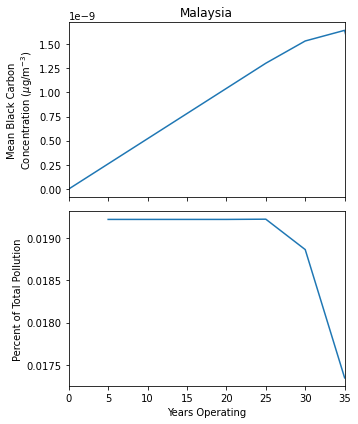

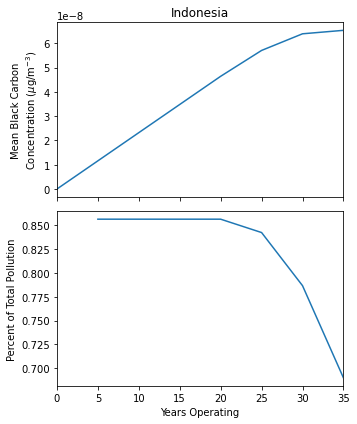

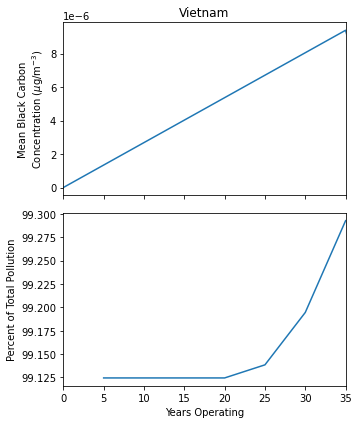

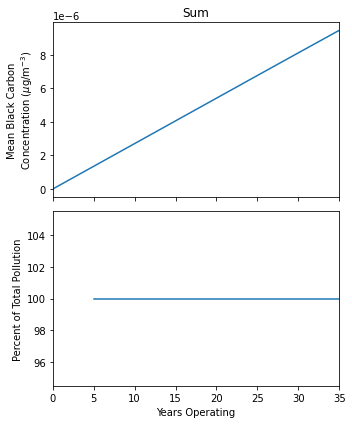

In [13]:
for emis_loc in emission_locs:
    fig, (ax1,ax2) = plt.subplots(2,1, figsize = [5,6], sharex = True)
    ds.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0).plot(ax = ax1)
    ax1.set_xlim(0,35)
    ax1.set_title(emis_loc.capitalize())
    ax1.set_xlabel('')
    ax1.set_ylabel('Mean Black Carbon\nConcentration ($\mu$g/m$^{-3}$)')
    
    ((ds.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0)/
      ds.sel(emis_loc = 'SUM', receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0))*100).plot(ax = ax2)
    ax2.set_title('')
    ax2.set_xlabel('Years Operating')
    ax2.set_ylabel('Percent of Total Pollution')
    plt.tight_layout()

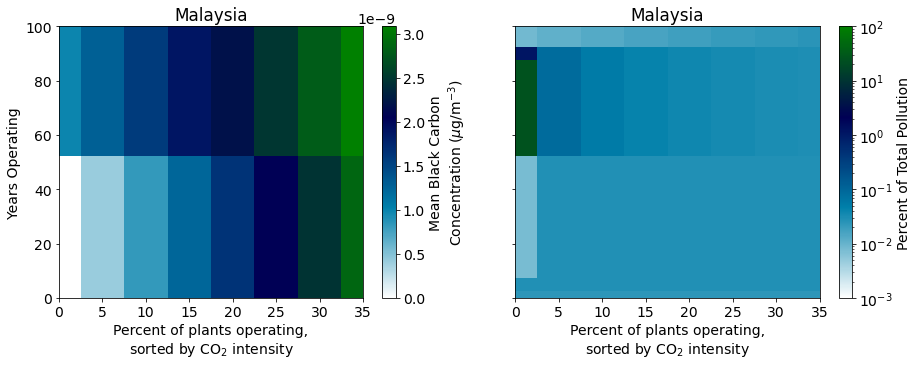

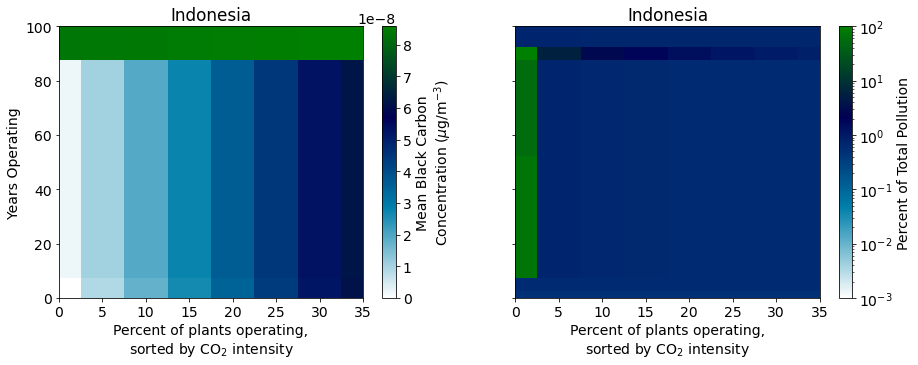

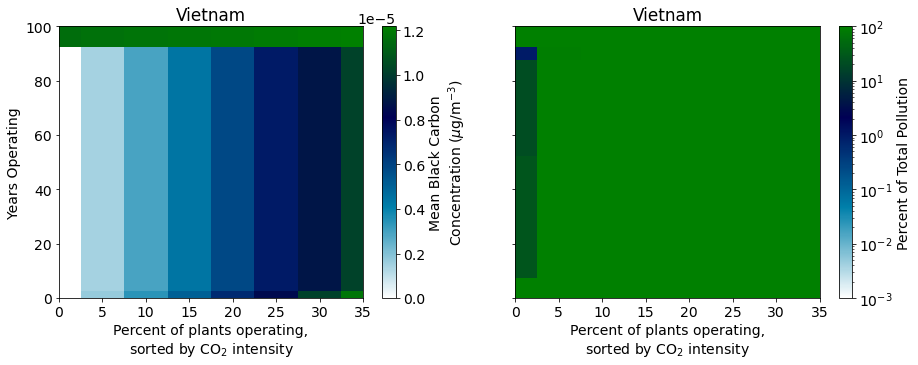

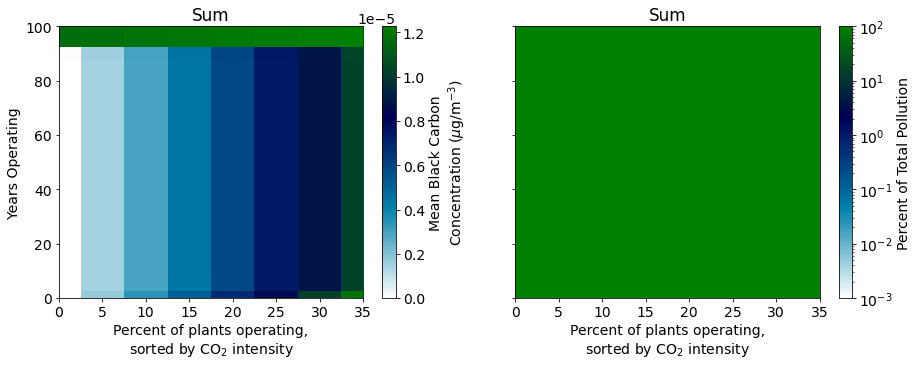

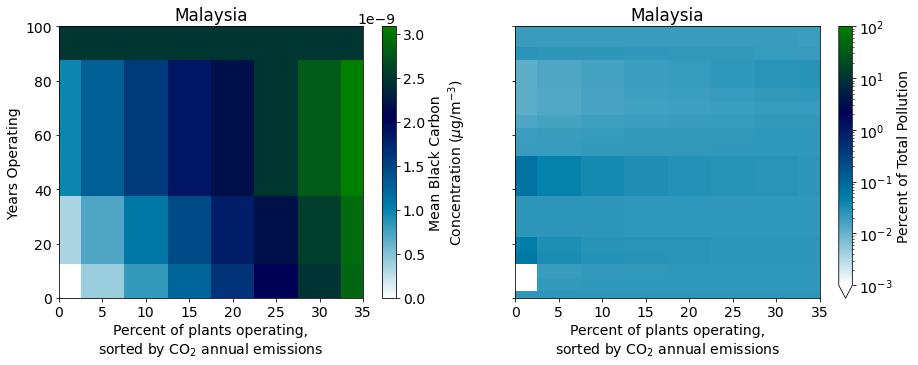

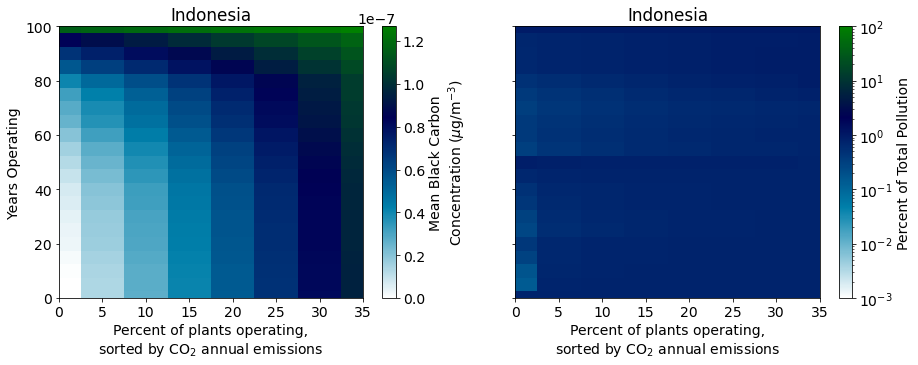

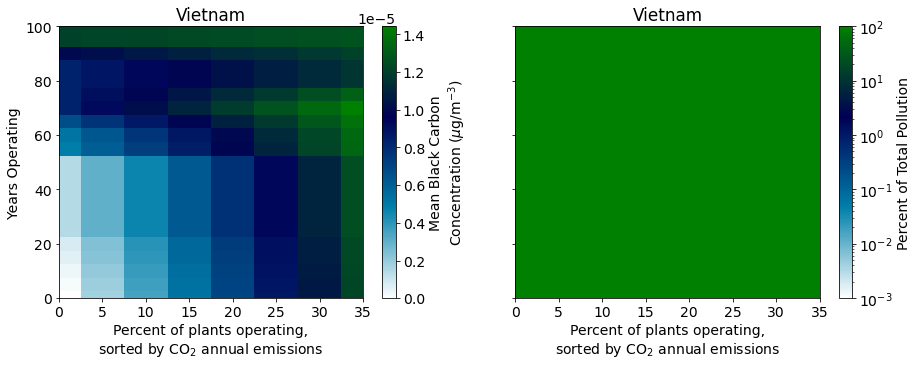

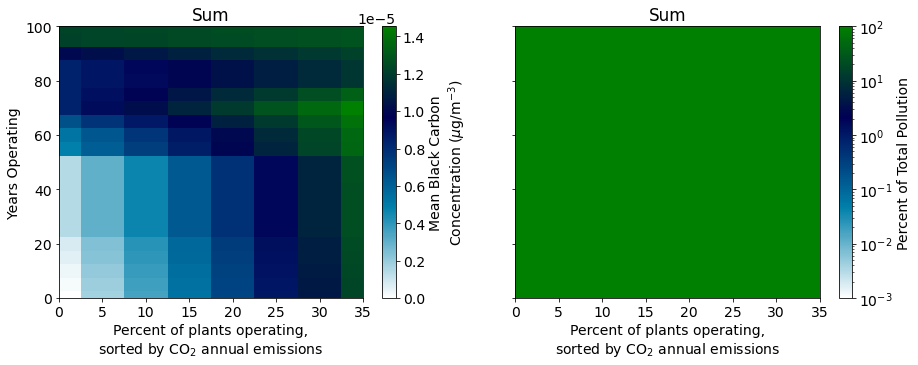

In [243]:
matplotlib.rcParams.update({'font.size': 14})
xlabels = {'intensity_co2':'CO$_2$ intensity','annual_co2':'CO$_2$ annual emissions'}
for shutdown_tp in ['intensity_co2','annual_co2']:
    for emis_loc in emission_locs:
        fig, (ax1,ax2) = plt.subplots(1,2, figsize = [15,5], sharey = True)
        ds.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = shutdown_tp).plot(ax = ax1, cmap = 'ocean_r',cbar_kwargs = {'label': 'Mean Black Carbon\nConcentration ($\mu$g/m$^{-3}$)'})
        ax1.set_xlim(0,35)
        ax1.set_title(emis_loc.capitalize()) 
        ax1.set_ylim(0,100)
        ax1.set_ylabel(f'Percent of plants operating,\nsorted by {xlabels[shutdown_tp]}')
        ax1.set_xlabel('Years Operating')

        ((ds.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = shutdown_tp)/ds.sel(emis_loc = 'SUM', receptor_loc = 'China', shutdown_type = shutdown_tp))*100).plot(ax = ax2, norm=matplotlib.colors.LogNorm(vmin = 1e-3, vmax = 100),
            cbar_kwargs = {'label': 'Percent of Total Pollution'}, cmap = 'ocean_r')
        ax2.set_xlim(0,35)
        ax2.set_ylim(0,100)
        ax2.set_title(emis_loc.capitalize())
        ax2.set_ylabel('')
        
        ax2.set_xlabel('Years Operating')

## Sum vs. percents

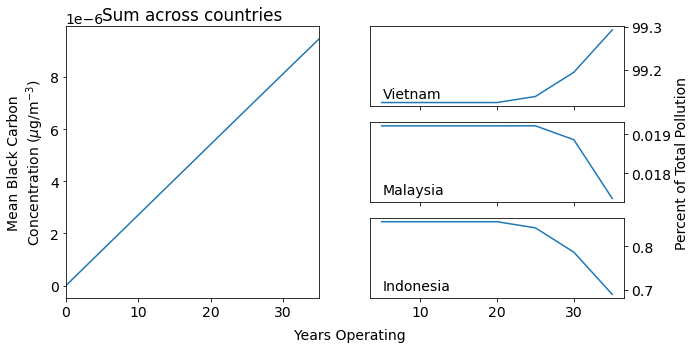

In [253]:
fig = plt.figure(figsize = [10,5])
gs = GridSpec(3, 2, figure = fig)
ax1 = fig.add_subplot(gs[:,0])
ds.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0).plot(ax = ax1)
ax1.set_xlim(0,35)
ax1.set_title('Sum across countries')
ax1.set_xlabel('')
ax1.set_ylabel('Mean Black Carbon\nConcentration ($\mu$g/m$^{-3}$)')

ax2 = fig.add_subplot(gs[0,1])
((ds.sel(emis_loc = 'VIETNAM', receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0)/
  ds.sel(emis_loc = 'SUM', receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0))*100).plot(ax = ax2)
ax2.set_title('')
ax2.tick_params(labelbottom=False)
ax2.set_xlabel(None)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.text(x = .05, y = .1, s = 'Vietnam', transform=ax2.transAxes)

ax3 = fig.add_subplot(gs[1,1])
((ds.sel(emis_loc = 'MALAYSIA', receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0)/
  ds.sel(emis_loc = 'SUM', receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0))*100).plot(ax = ax3)
ax3.set_title('')
ax3.tick_params(labelbottom=False)
ax3.set_xlabel(None)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.text(x = .05, y = .1, s = 'Malaysia', transform=ax3.transAxes)

ax4 = fig.add_subplot(gs[2,1])
((ds.sel(emis_loc = 'INDONESIA', receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0)/
  ds.sel(emis_loc = 'SUM', receptor_loc = 'China', shutdown_type = 'retire_age').sel(percent = 0))*100).plot(ax = ax4)
ax4.set_title('')
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.set_xlabel('')
ax4.text(x = .05, y = .1, s = 'Indonesia', transform=ax4.transAxes)

ax3.set_ylabel('Percent of Total Pollution')
#ax3.text(x = 1.3, y = 1, s ='Percent of Total Pollution', rotation = 'vertical', transform=ax3.transAxes)
ax1.text(x = .9, y = -0.15, s ='Years Operating', transform=ax1.transAxes)
plt.savefig('figures/retire_age_sum_vs_pct.png', dpi = 300, bbox_inches = 'tight')

## Dataframe for total CO2 emitted under each scenario

In [12]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year_annual(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    E = np.zeros(len(time_array))
    test_array = np.where(time_array <= year_early, True, False)
    E += test_array* df.loc[df.ANNUALCO2 >= CO2_val]['ANNUALCO2'].sum()
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        E += test_array* df.loc[(df.ANNUALCO2 < CO2_val) & (df.Year_of_Commission == year_comis)]['ANNUALCO2'].sum()

    
    return(E)


#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year_weighted(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        year_early is the number of years the plant runs
        min_comission_yr is the earliest year a plant was built and is where our timeline starts
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant'''
    min_comission_yr = df['Year_of_Commission'].min()
    E = np.zeros(len(time_array))
    test_array = np.where(time_array <= year_early, True, False)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['ANNUALCO2'].sum()
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['ANNUALCO2'].sum()


    
    return(E)


# In[12]:



In [13]:
E_CO2_all_opts_annual = {}
for year in years:
    E_CO2_all_opts_annual[year] = {}
    for r in percents:
        E_CO2_all_opts_annual[year][r] = early_retirement_by_CO2_year_annual(year, CGP_df, np.percentile(CGP_df['ANNUALCO2'].dropna(),r), time_array, 40) 
        E_CO2_all_opts_annual[year][r] = E_CO2_all_opts_annual[year][r].sum()

In [14]:

E_CO2_all_opts_weighted = {}
for year in years:
    E_CO2_all_opts_weighted[year] = {}
    for r in percents:
        E_CO2_all_opts_weighted[year][r] = early_retirement_by_CO2_year_weighted(year, CGP_df, 
                                                               np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r), time_array, 40)
        E_CO2_all_opts_weighted[year][r] = E_CO2_all_opts_weighted[year][r].sum()
print('Emis profiiles created')

Emis profiiles created


In [15]:
CO2_weighted_df = pd.DataFrame(E_CO2_all_opts_weighted)
CO2_annual_df = pd.DataFrame(E_CO2_all_opts_annual)

In [16]:
## convert to GtCO2 via multiplying by 1e-9

In [17]:
CO2_weighted_ds = CO2_weighted_df.rename_axis(index='percent', columns='year').stack().to_xarray()

In [18]:
ds_extend_co2 = CO2_weighted_ds.copy()
for yr in CO2_weighted_ds.year.values[1:]:
    print(yr)
    ds_extend_co2.loc[dict(year = yr)].loc[dict(percent = 0)] = ds_extend_co2.loc[dict(year = yr - 5)].loc[dict(percent = 55)]
    
ds_extend_co2 = ds_extend_co2.where(ds_extend_co2['percent'].isin([0,5,10,95,100]),drop = True)

5
10
15
20
25
30
35
40


/tmp/ipykernel_10520/897439942.py:2: UserWarning: linewidths is ignored by contourf
  contours = ax1.contourf(years, percents, ds_extend_co2.interp(percent = np.arange(0,105,5))*1e-9, cmap = 'gist_heat_r',
/tmp/ipykernel_10520/897439942.py:8: UserWarning: linewidths is ignored by contourf
  contours = ax2.contourf(years, percents, CO2_annual_df[:].values*1e-9, cmap = 'gist_heat_r',


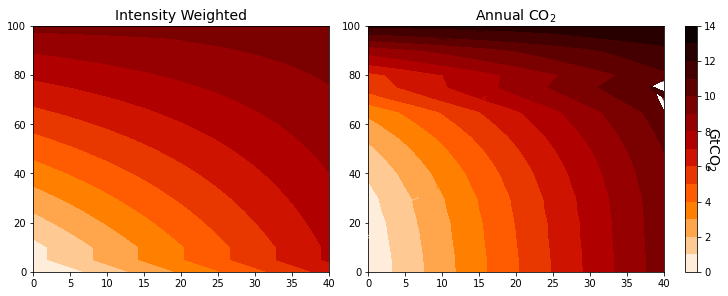

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [10,4], constrained_layout = True)
contours = ax1.contourf(years, percents, ds_extend_co2.interp(percent = np.arange(0,105,5))*1e-9, cmap = 'gist_heat_r', 
                   levels =np.arange(0,15,1), linewidths = 2)
# plt.colorbar()
# plt.clabel(contours, fontsize=8, inline = True)
ax1.set_title('Intensity Weighted', fontsize = 14)

contours = ax2.contourf(years, percents, CO2_annual_df[:].values*1e-9, cmap = 'gist_heat_r', 
                   levels = np.arange(0,15,1), linewidths = 2)
cbar = plt.colorbar(contours, ax = ax2)
plt.clabel(contours, fontsize=8, inline = True)
cbar.set_label('GtCO$_2$', rotation=270, fontsize = 14)
ax2.set_title('Annual CO$_2$', fontsize = 14)

plt.savefig('figures/co2_contours.png', dpi = 350, bbox_inches = 'tight')

## Plot CO2 and Concentration of BC

In [19]:
ds_extend = ds.copy()
for yr in ds.year.values[1:]:
    print(yr)
    ds_extend.loc[dict(year = yr)].loc[dict(percent = 0)] = ds_extend.loc[dict(year = yr - 5)].loc[dict(percent = 90)]
    
ds_extend = ds_extend.where(ds_extend['percent'].isin([0,5,10,95,100]),drop = True)

5
10
15
20
25
30
35
40


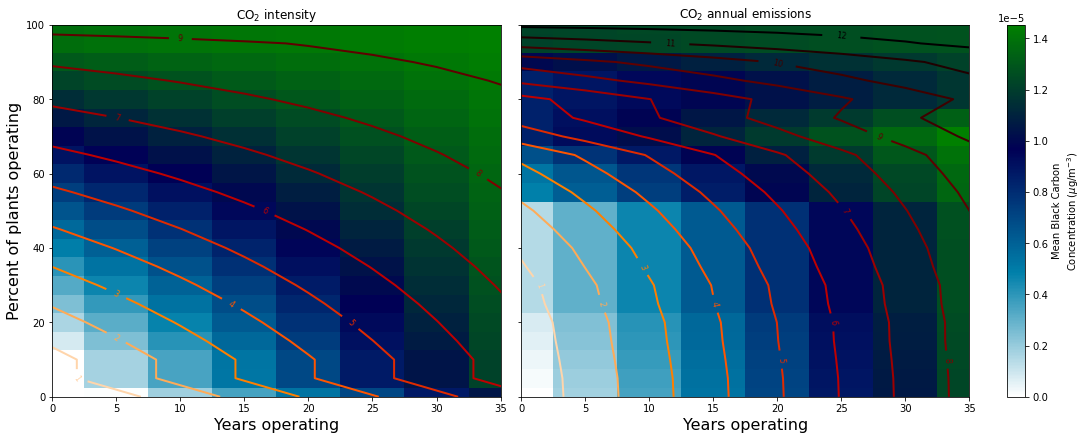

In [24]:
co2_choice = {'intensity_co2':ds_extend_co2.interp(percent = np.arange(0,105,5)), 'annual_co2':CO2_annual_df}
xlabels = {'intensity_co2':'CO$_2$ intensity','annual_co2':'CO$_2$ annual emissions'}


for emis_loc in ['SUM']:
    fig, axes = plt.subplots(1,2, figsize = [15,6], sharey = True, constrained_layout = True)
    for idx, s_type in enumerate(['intensity_co2','annual_co2']):
        ax = axes[idx]
        if s_type == 'intensity_co2':
            cbar=False
            cbar_args = None
            ds_opt = ds_extend
            ds_cont = co2_choice[s_type]
        elif s_type == 'annual_co2':
            cbar = True
            cbar_args = {'label': 'Mean Black Carbon\nConcentration ($\mu$g/m$^{-3}$)'}
            ds_opt = ds
            ds_cont = co2_choice[s_type][:].values
        ds_opt.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = s_type).interp(percent = np.arange(0,105,5)).plot(ax = ax, cmap = 'ocean_r', add_colorbar = cbar, cbar_kwargs = cbar_args)
        
        
        
        contours = ax.contour(years, percents, ds_cont*1e-9, cmap = 'gist_heat_r', 
                           levels = np.arange(0,13,1), linewidths = 2)
        plt.clabel(contours, fontsize=8, inline = True)
        plt.xlim(0,35)
        #plt.plot(92,40-24.2, 'k*', markersize = 12)
        ax.set_xlabel('Years operating', fontsize = 16)
        ax.set_ylim(0,100)
        ax.set_xlim(0,35)
        ax.set_title(xlabels[s_type])
    axes[0].set_ylabel(f'Percent of plants operating', fontsize = 16)
    axes[1].set_ylabel(None)
    plt.savefig(f'figures/china_poll_BC_contours_co2.png', bbox_inches = 'tight', dpi = 350)



In [20]:
co2_choice = {'intensity_co2':ds_extend_co2.interp(percent = np.arange(0,105,5)), 'annual_co2':CO2_annual_df}
xlabels = {'intensity_co2':'CO$_2$ intensity','annual_co2':'CO$_2$ annual emissions'}


for emis_loc in emission_locs:
    fig, axes = plt.subplots(1,2, figsize = [15,6], sharey = True, constrained_layout = True)
    for idx, s_type in enumerate(['intensity_co2','annual_co2']):
        ax = axes[idx]
        if s_type == 'intensity_co2':
            cbar=False
            cbar_args = None
            ds_opt = ds_extend
            ds_cont = co2_choice[s_type]
        elif s_type == 'annual_co2':
            cbar = True
            cbar_args = {'label': 'Mean Black Carbon\nConcentration ($\mu$g/m$^{-3}$)'}
            ds_opt = ds
            ds_cont = co2_choice[s_type][:].values
        ((ds_opt.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = s_type)).interp(percent = np.arange(0,105,5)).plot(ax = ax, cmap = 'ocean_r', 
                                                                                                                                  add_colorbar = cbar, cbar_kwargs = cbar_args)
        
        
        
        #contours = ax.contour(years, percents, ds_cont*1e-9, cmap = 'gist_heat_r', 
                       #    levels = np.arange(0,13,1), linewidths = 2)
        #plt.clabel(contours, fontsize=8, inline = True)
        plt.xlim(0,35)
        #plt.plot(92,40-24.2, 'k*', markersize = 12)
        ax.set_xlabel('Years operating', fontsize = 16)
        ax.set_ylim(0,100)
        ax.set_xlim(0,35)
        ax.set_title(xlabels[s_type])
    axes[0].set_ylabel(f'Percent of plants operating', fontsize = 16)
    axes[1].set_ylabel(None)
    plt.savefig(f'figures/china_poll_BC_contours_co2_{emis_loc}.png', bbox_inches = 'tight', dpi = 350)



SyntaxError: invalid syntax (3513700585.py, line 27)

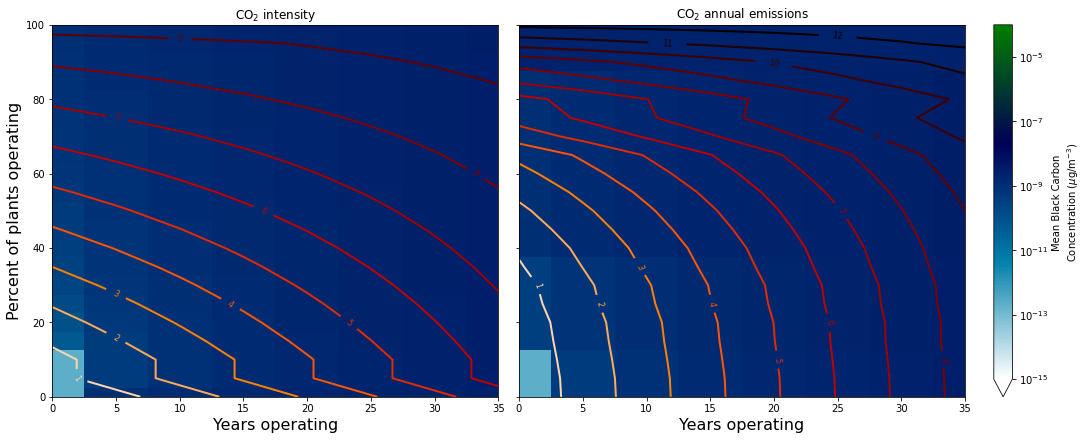

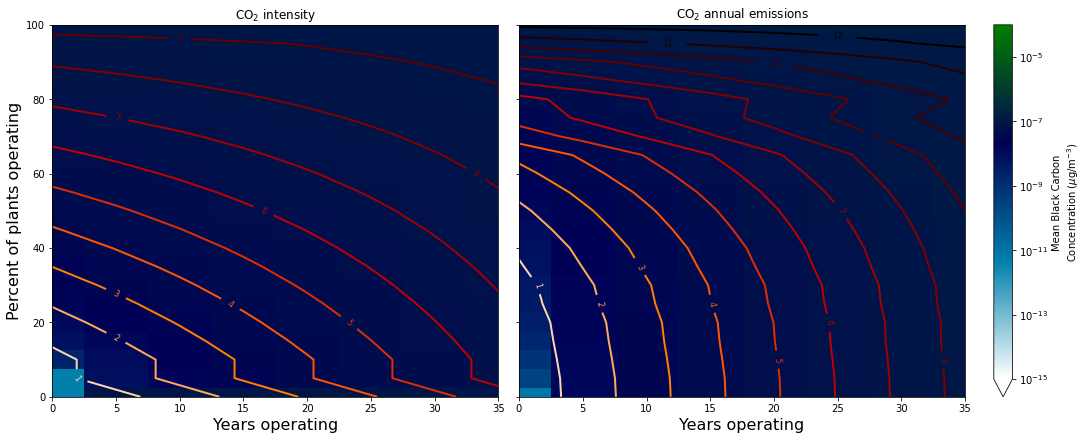

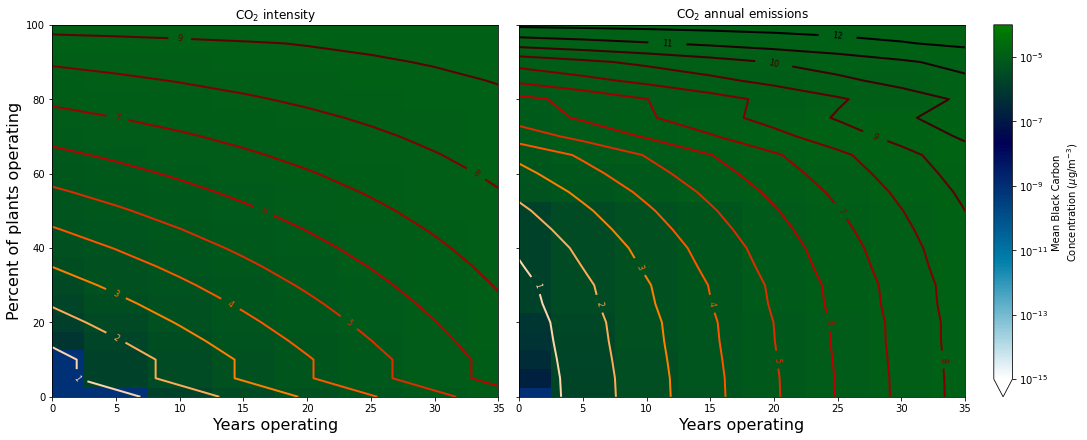

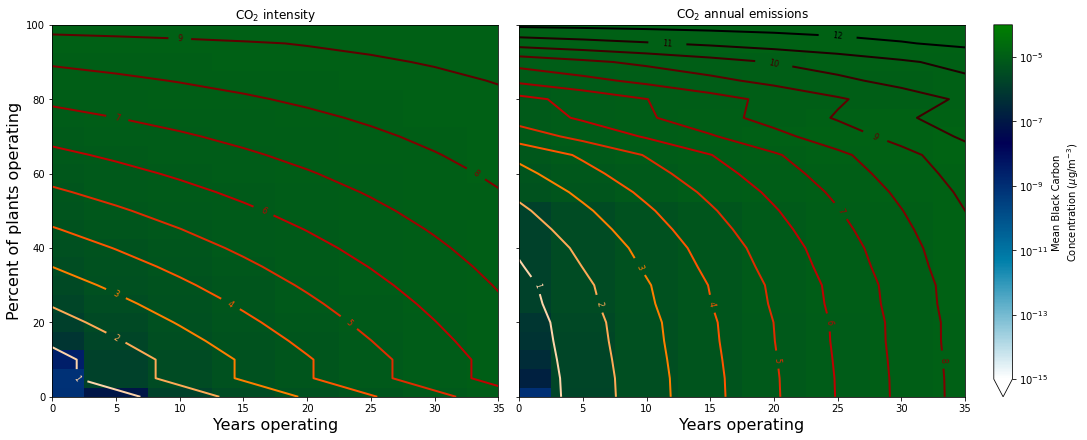

In [42]:
co2_choice = {'intensity_co2':ds_extend_co2.interp(percent = np.arange(0,105,5)), 'annual_co2':CO2_annual_df}
xlabels = {'intensity_co2':'CO$_2$ intensity','annual_co2':'CO$_2$ annual emissions'}


for emis_loc in emission_locs:
    fig, axes = plt.subplots(1,2, figsize = [15,6], sharey = True, constrained_layout = True)
    for idx, s_type in enumerate(['intensity_co2','annual_co2']):
        ax = axes[idx]
        if s_type == 'intensity_co2':
            cbar=False
            cbar_args = None
            ds_opt = ds_extend
            ds_cont = co2_choice[s_type]
        elif s_type == 'annual_co2':
            cbar = True
            cbar_args = {'label': 'Mean Black Carbon\nConcentration ($\mu$g/m$^{-3}$)'}
            ds_opt = ds
            ds_cont = co2_choice[s_type][:].values
        ds_opt.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = s_type).interp(percent = np.arange(0,105,5)).plot(ax = ax, cmap = 'ocean_r', 
                                                                                                                                  add_colorbar = cbar, cbar_kwargs = cbar_args, norm=matplotlib.colors.LogNorm(vmin = 1e-15, vmax = 1e-4))
        
        
        
        contours = ax.contour(years, percents, ds_cont*1e-9, cmap = 'gist_heat_r', 
                           levels = np.arange(0,13,1), linewidths = 2)
        plt.clabel(contours, fontsize=8, inline = True)
        plt.xlim(0,35)
        #plt.plot(92,40-24.2, 'k*', markersize = 12)
        ax.set_xlabel('Years operating', fontsize = 16)
        ax.set_ylim(0,100)
        ax.set_xlim(0,35)
        ax.set_title(xlabels[s_type])
    axes[0].set_ylabel(f'Percent of plants operating', fontsize = 16)
    axes[1].set_ylabel(None)
    plt.savefig(f'figures/china_poll_BC_contours_co2_{emis_loc}.png', bbox_inches = 'tight', dpi = 350)



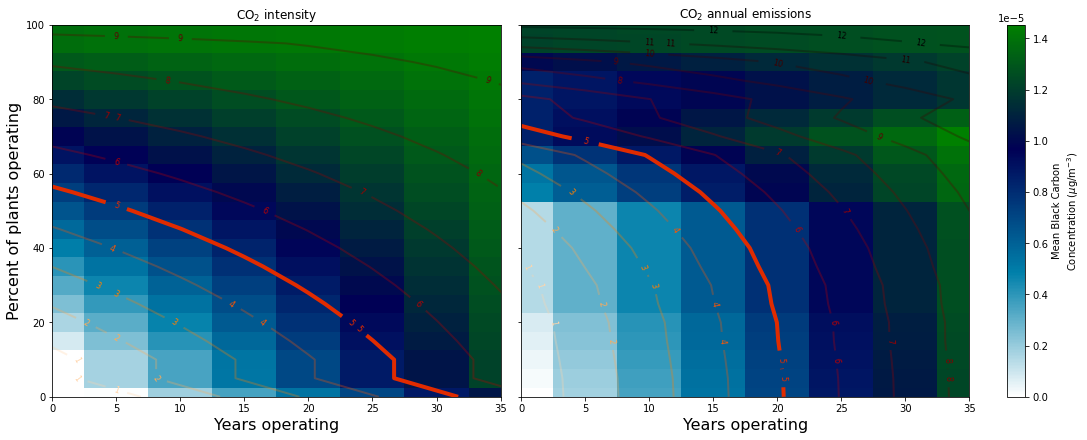

In [23]:
co2_choice = {'intensity_co2':ds_extend_co2.interp(percent = np.arange(0,105,5)), 'annual_co2':CO2_annual_df}
xlabels = {'intensity_co2':'CO$_2$ intensity','annual_co2':'CO$_2$ annual emissions'}


for emis_loc in ['SUM']:
    fig, axes = plt.subplots(1,2, figsize = [15,6], sharey = True, constrained_layout = True)
    for idx, s_type in enumerate(['intensity_co2','annual_co2']):
        ax = axes[idx]
        if s_type == 'intensity_co2':
            cbar=False
            cbar_args = None
            ds_opt = ds_extend
            ds_cont = co2_choice[s_type]
        elif s_type == 'annual_co2':
            cbar = True
            cbar_args = {'label': 'Mean Black Carbon\nConcentration ($\mu$g/m$^{-3}$)'}
            ds_opt = ds
            ds_cont = co2_choice[s_type][:].values
        ds_opt.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = s_type).interp(percent = np.arange(0,105,5)).plot(ax = ax, cmap = 'ocean_r', add_colorbar = cbar, cbar_kwargs = cbar_args)
        
        
        
        contours = ax.contour(years, percents, ds_cont*1e-9, cmap = 'gist_heat_r', 
                           levels = np.arange(0,13,1), linewidths = 2)
        plt.clabel(contours, fontsize=8, inline = True)
        contours.collections[5].set_linewidth(4)
        for i in [0,1,2,3,4,6,7,8,9,10,11,12]:
            contours.collections[i].set_alpha(.3)
        plt.clabel(contours, fontsize=8, inline = True)
        plt.xlim(0,35)
        #plt.plot(92,40-24.2, 'k*', markersize = 12)
        ax.set_xlabel('Years operating', fontsize = 16)
        ax.set_ylim(0,100)
        ax.set_xlim(0,35)
        ax.set_title(xlabels[s_type])
    axes[0].set_ylabel(f'Percent of plants operating', fontsize = 16)
    axes[1].set_ylabel(None)
    plt.savefig(f'figures/china_poll_BC_contours_co2.png', bbox_inches = 'tight', dpi = 350)



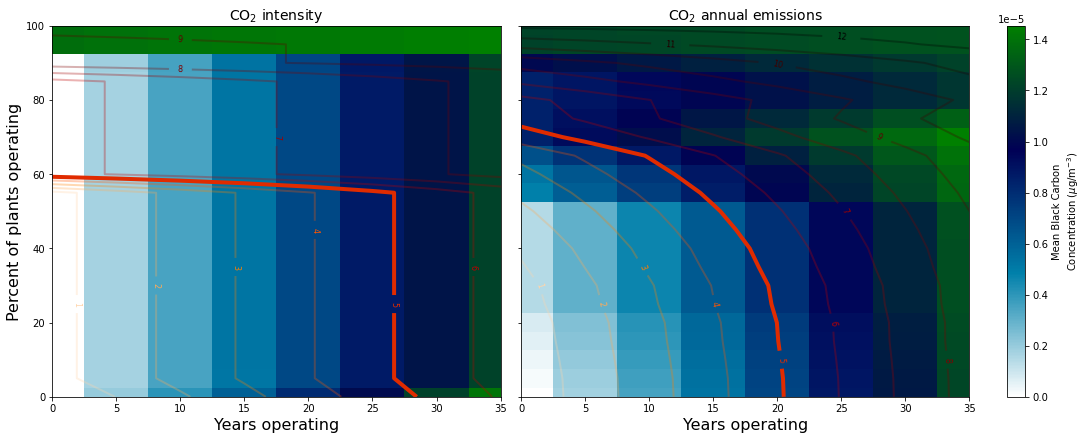

In [22]:
co2_choice = {'intensity_co2':CO2_weighted_df, 'annual_co2':CO2_annual_df}
xlabels = {'intensity_co2':'CO$_2$ intensity','annual_co2':'CO$_2$ annual emissions'}


for emis_loc in ['SUM']:
    fig, axes = plt.subplots(1,2, figsize = [15,6], sharey = True, constrained_layout = True)
    for idx, s_type in enumerate(['intensity_co2','annual_co2']):
        ax = axes[idx]
        if s_type == 'intensity_co2':
            cbar=False
            cbar_args = None
        elif s_type == 'annual_co2':
            cbar = True
            cbar_args = {'label': 'Mean Black Carbon\nConcentration ($\mu$g/m$^{-3}$)'}
        ds.sel(emis_loc = emis_loc, receptor_loc = 'China', shutdown_type = s_type).plot(ax = ax, cmap = 'ocean_r', add_colorbar = cbar, cbar_kwargs = cbar_args)
        contours = ax.contour(years, percents, co2_choice[s_type][:].values*1e-9, cmap = 'gist_heat_r', 
                           levels = np.arange(0,13,1), linewidths = 2)
        contours.collections[5].set_linewidth(4)
        for i in [0,1,2,3,4,6,7,8,9,10,11,12]:
            contours.collections[i].set_alpha(.3)
        plt.clabel(contours, fontsize=8, inline = True)
        plt.xlim(0,35)
        #plt.plot(92,40-24.2, 'k*', markersize = 12)
        ax.set_xlabel('Years operating', fontsize = 16)
        ax.set_ylim(0,100)
        ax.set_xlim(0,35)
        ax.set_title(xlabels[s_type], fontsize = 14)
    axes[0].set_ylabel(f'Percent of plants operating', fontsize = 16)
    axes[1].set_ylabel(None)
    plt.savefig(f'figures/china_poll_BC_contours_individual_highlight.png', bbox_inches = 'tight', dpi = 350)



## Number of plants open

In [112]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    E = np.zeros(len(time_array))
    test_array = np.where(time_array <= year_early, True, False)
    E += test_array* df.loc[df.ANNUALCO2 >= CO2_val]['UNITID'].count()
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        E += test_array* df.loc[(df.ANNUALCO2 < CO2_val) & (df.Year_of_Commission == year_comis)]['UNITID'].count()

    
    return(E)

#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year_mw(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    E = np.zeros(len(time_array))
    test_array = np.where(time_array <= year_early, True, False)
    E += test_array* df.loc[df.ANNUALCO2 >= CO2_val]['MW'].sum()
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        E += test_array* df.loc[(df.ANNUALCO2 < CO2_val) & (df.Year_of_Commission == year_comis)]['MW'].sum()

    
    return(E)

#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year_mw_weighted(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    E = np.zeros(len(time_array))
    test_array = np.where(time_array <= year_early, True, False)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['MW'].sum()
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['MW'].sum()

    
    return(E)


In [101]:
E_num_plants = {}
for year in years:
    E_num_plants[year] = {}
    for r in np.arange(1,101):
        E_num_plants[year][r] = early_retirement_by_CO2_year(year, CGP_df, np.percentile(CGP_df['ANNUALCO2'].dropna(),r), np.arange(0,50), 40) # was CO2_weighted_capacity_1000tonsperMW but now annual
        

In [109]:
E_mw_plants = {}
for year in years:
    E_mw_plants[year] = {}
    for r in np.arange(1,101):
        E_mw_plants[year][r] = early_retirement_by_CO2_year_mw(year, CGP_df, np.percentile(CGP_df['ANNUALCO2'].dropna(),r), np.arange(0,50), 40) # was CO2_weighted_capacity_1000tonsperMW but now annual

In [113]:
E_mw_weighted_plants = {}
for year in years:
    E_mw_weighted_plants[year] = {}
    for r in np.arange(1,101):
        E_mw_weighted_plants[year][r] = early_retirement_by_CO2_year_mw_weighted(year, CGP_df, np.percentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'].dropna(),r), np.arange(0,50), 40) # was CO2_weighted_capacity_1000tonsperMW but now annual
        

In [114]:
num_plants_df = pd.DataFrame(E_num_plants).T
mw_plants_df = pd.DataFrame(E_mw_plants).T
mw_weighted_plants_df = pd.DataFrame(E_mw_weighted_plants).T

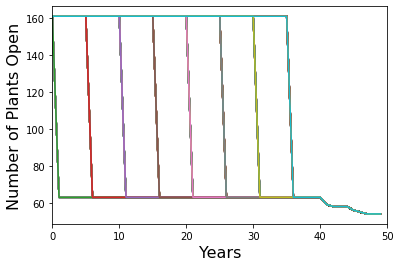

In [106]:
for year in np.arange(0,100)[::2]:
    for r in np.arange(0,40)[::5]:
        plt.plot(num_plants_df[yr].loc[r])
plt.xlim(0,50)
plt.xlabel('Years', fontsize = 16)
plt.ylabel('Number of Plants Open', fontsize = 16)
plt.savefig('figures/ex_plants_trajectory.pdf', bbox_inches = 'tight', dpi = 350)

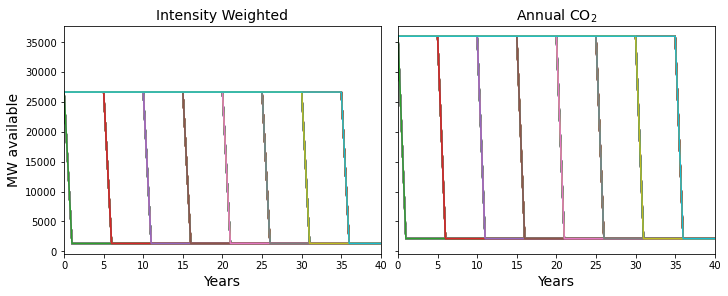

In [124]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = [10,4], constrained_layout = True)
for year in np.arange(0,100)[::2]:
    for r in np.arange(0,40)[::5]:
        ax1.plot(mw_weighted_plants_df[yr].loc[r])
ax1.set_xlim(0,40)
ax1.set_xlabel('Years', fontsize = 14)
ax1.set_ylabel('MW available', fontsize = 14)
ax1.set_title('Intensity Weighted', fontsize = 14)

for year in np.arange(0,100)[::2]:
    for r in np.arange(0,40)[::5]:
        ax2.plot(mw_plants_df[yr].loc[r])
ax2.set_xlim(0,40)
ax2.set_xlabel('Years', fontsize = 14)
ax2.set_title('Annual CO$_2$', fontsize = 14)
plt.savefig('figures/mw_plants_trajectory.pdf', bbox_inches = 'tight', dpi = 350)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = [10,4], constrained_layout = True)
for year in np.arange(0,100)[::2]:
    for r in np.arange(0,40)[::5]:
        ax1.plot(mw_weighted_plants_df[yr].loc[r])
ax1.set_xlim(0,40)
ax1.set_xlabel('Years', fontsize = 14)
ax1.set_ylabel('MW available', fontsize = 14)
ax1.set_title('Intensity Weighted', fontsize = 14)

        ax2.plot(mw_plants_df[yr].loc[r])
ax2.set_xlim(0,40)
ax2.set_xlabel('Years', fontsize = 14)
ax2.set_title('Annual CO$_2$', fontsize = 14)
#plt.savefig('figures/mw_plants_trajectory.pdf', bbox_inches = 'tight', dpi = 350)

In [ ]:

plt.plot(num_plants_df[20].loc[20])
plt.plot(num_plants_df[15].loc[5])
plt.xlim(0,70)
plt.xlabel('Years', fontsize = 16)
plt.ylabel('Number of Plants Open', fontsize = 16)
plt.savefig('figures/ex_plants_trajectory.pdf', bbox_inches = 'tight', dpi = 350)

## Country/Map Plots

KeyboardInterrupt: 

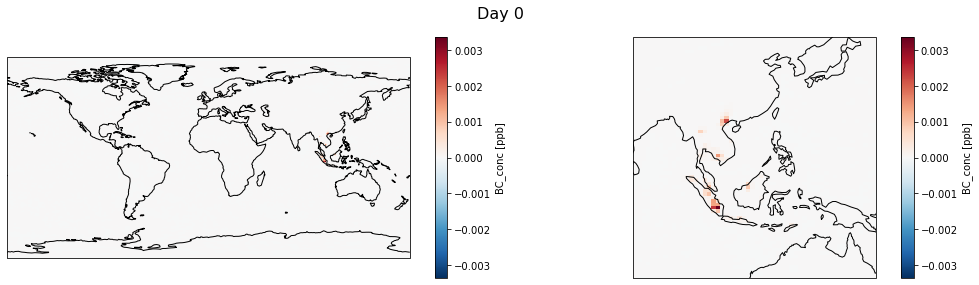

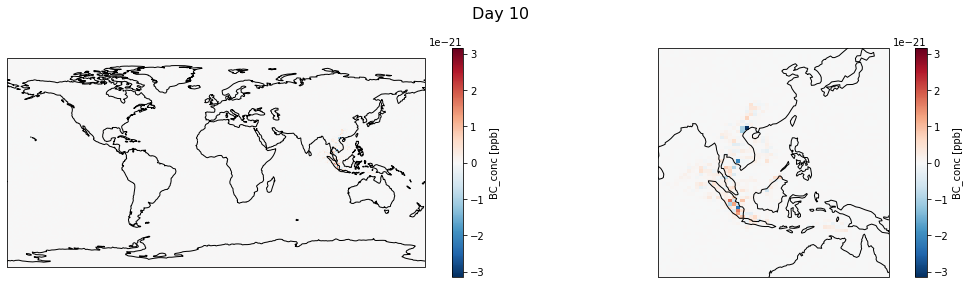

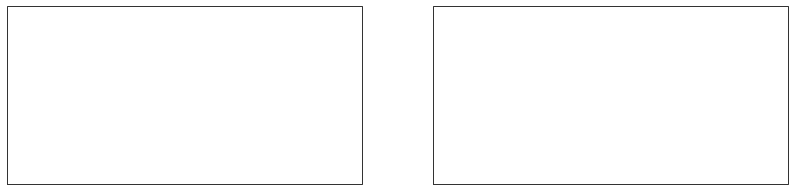

In [319]:
for t in [0,10,20,30]:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
    ##### global view #######
    (ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].isel(s = t*365)).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                                #norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16), add_colorbar = False,
                                                                               cmap = 'RdBu_r')
    ax1.coastlines()
    ax1.set_title('')
    ##### Zoomed in ########
    (ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].isel(s = t*365)).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                               # norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16),
                                                                               cmap = 'RdBu_r')
    ax2.coastlines()
    ax2.add_feature(cfeat.STATES)
    ax2.set_extent([80,150,-20,40])
    ax2.set_title('')
    plt.suptitle(f'Day {t}', fontsize = 16);
    plt.tight_layout()
    #plt.savefig("figures/GF_video/" + str(t).zfill(4) + ".png", dpi = 350, bbox_inches = 'tight')
    #plt.close();

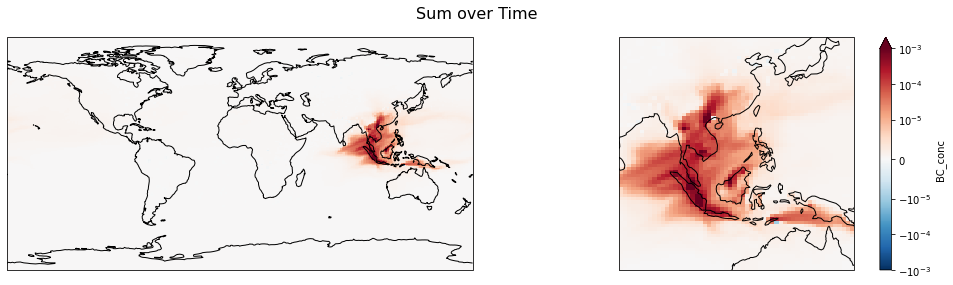

In [321]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].sum(dim = 's')).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-5, 1, -1e-3, 1e-3), add_colorbar = False,
                                                                           cmap = 'RdBu_r')
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].sum(dim = 's')).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-5, 1, -1e-3, 1e-3),
                                                                           cmap = 'RdBu_r')
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Sum over Time', fontsize = 16);
plt.tight_layout()
plt.savefig("figures/0_100_yr_pct.pdf", dpi = 350, bbox_inches = 'tight')
#plt.close();

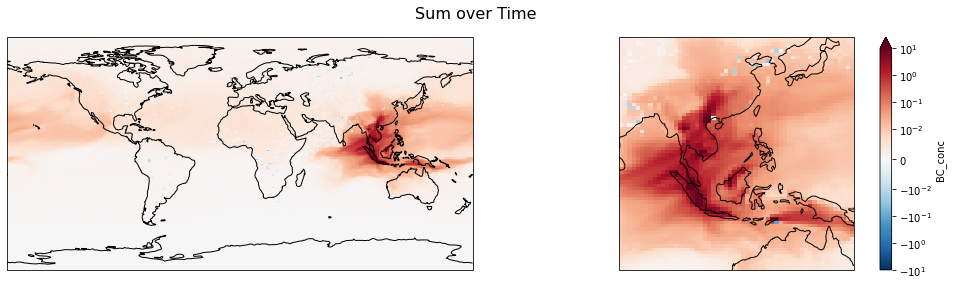

In [ ]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(ds.sel(year_shutdown = 30, percent = 30)['BC_conc'].sum(dim = 's')).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-2, 1, -10, 10), add_colorbar = False,
                                                                           cmap = 'RdBu_r')
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(ds.sel(year_shutdown = 30, percent = 30)['BC_conc'].sum(dim = 's')).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-2, 1, -10, 10),
                                                                           cmap = 'RdBu_r')
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Sum over Time', fontsize = 16);
plt.tight_layout()
plt.savefig("figures/30_30_yr_pct.pdf", dpi = 350, bbox_inches = 'tight')
#plt.close();

## Example Emissions Profile

In [136]:
def early_retirement_by_CO2_weighted(year_early, df, CO2_val, time_array, shutdown_years):
    ''' Shutdown a plant early based on its capacity weighted CO2 emissions. Shutdowns occur by the percentile of the plant (eg: top 10%, top 90%). The df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        year_early is the number of years the plant runs
        min_comission_yr is the earliest year a plant was built and is where our timeline starts
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant'''
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365
    E = np.zeros(len(time_array))

    test_array = np.where(time_array <= year_early*365, True, False)

    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['BC_(g/day)'].sum()

    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        test_array = np.where((time_array <= (year_comis-min_comission_yr)*365 + shutdown_days), True, False)

        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum()


    
    return(E)

E_CO2_all_opts = {}
for year in years:
    E_CO2_all_opts[year] = {}
    for r in np.arange(1,101):
        E_CO2_all_opts[year][r] = early_retirement_by_CO2_weighted(year, CGP_df, np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'].dropna(),r), time_array, 40)
print('Emissions profiles based on weighted capacity of CO2 emissions percentiles createdd')


Emissions profiles based on weighted capacity of CO2 emissions percentiles createdd


In [142]:
emis_df = pd.DataFrame(E_CO2_all_opts).T

Text(0, 0.5, 'Number of Plants Open')

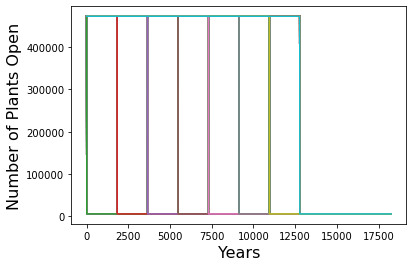

In [144]:
for year in np.arange(0,100)[::2]:
    for r in np.arange(0,40)[::5]:
        plt.plot(emis_df[yr].loc[r])
#plt.xlim(0,50)
plt.xlabel('Years', fontsize = 16)
plt.ylabel('Number of Plants Open', fontsize = 16)
#plt.savefig('figures/ex_plants_trajectory.pdf', bbox_inches = 'tight', dpi = 350)

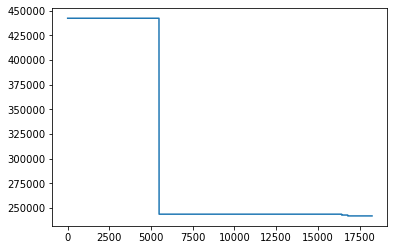

In [150]:
plt.plot(emis_df[80].loc[15])